In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp13.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_price,unit_perc_tax_substitution,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,6.341538,236.499676,6.563161,116.636923,0.836154,0.013077,0.018462,0.016154,0.018462,0.018462,...,0.010769,0.005385,0.008462,0.064615,0.018462,0.018462,0.006154,0.008462,0.010000,0.013077
std,3.596290,216.022433,4.026339,241.937405,0.370278,0.113648,0.134665,0.126116,0.134665,0.134665,...,0.103254,0.073210,0.091632,0.245941,0.134665,0.134665,0.078235,0.091632,0.099537,0.113648
min,1.000000,6.910000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,113.246433,3.641765,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,175.776013,6.827206,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,288.258913,9.416272,98.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,1903.950000,22.910000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_price,unit_perc_tax_substitution,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,205.618941,11.113689,664,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,245.817299,7.586042,225,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,216.730145,3.697939,211,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,206.905313,2.348998,634,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,199.342329,6.918881,1343,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y', 'prod_code'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
X_cols

['code',
 'month',
 'unit_price',
 'unit_perc_tax_substitution',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [8]:
df_dataset_v2[X_cols].head()

,code,month,unit_price,unit_perc_tax_substitution,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,205.618941,11.113689,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,245.817299,7.586042,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,216.730145,3.697939,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,206.905313,2.348998,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,199.342329,6.918881,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [9]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [10]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [11]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [12]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [13]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [15]:

# mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
# regressors['mlp_q'] = mlp_q

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [17]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [18]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [19]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5



In [20]:
metric_list = []

In [21]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MDAPE                MAPE            \
              mean        std      mean       std      mean       std   
r_name                                                                  
gb_q    190.954878  33.985301  0.664259  0.033659  2.362050  1.351359   
gbm     163.674738  18.618240  0.976700  0.100204  4.958935  0.683131   
gbm_q   188.443223  27.919341  0.698805  0.074491  2.505230  0.378493   

                 MSE                      MAE                   R2            
                mean           std       mean        std      mean       std  
r_name                                                                        
gb_q    37426.265825  11834.878429  81.779289  13.731812  0.323604  0.146673  
gbm     27078.285607   5856.711359  96.025293  11.651446  0.501614  0.054727  
gbm_q   36160.422952  10041.727494  87.640577  12.472461  0.342117  0.098861

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 179.4829
MAPE': 3.7065
MDAPE': 0.8920
MSE: 32214.1040
MAE: 90.8720
R2: 0.4269


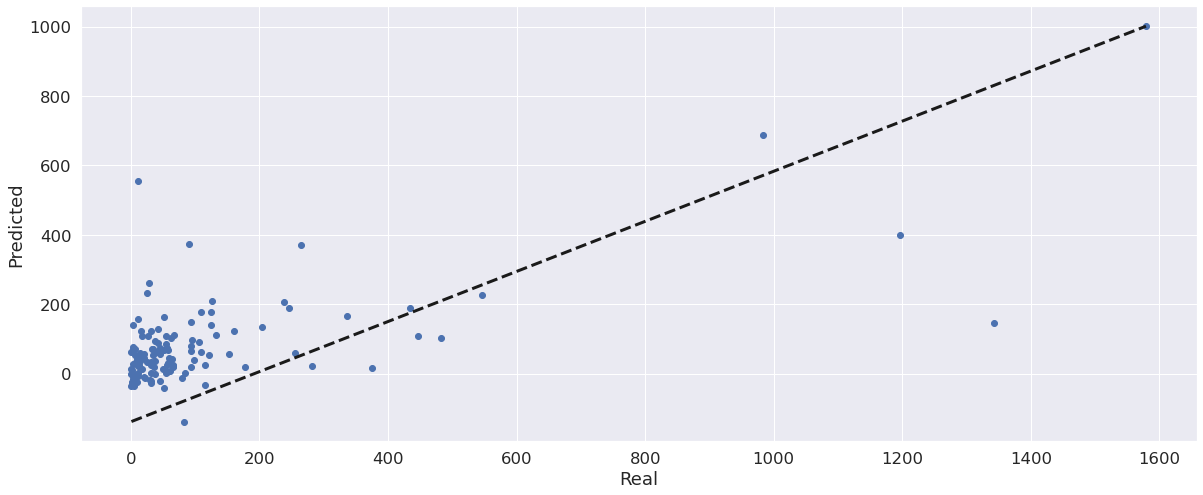

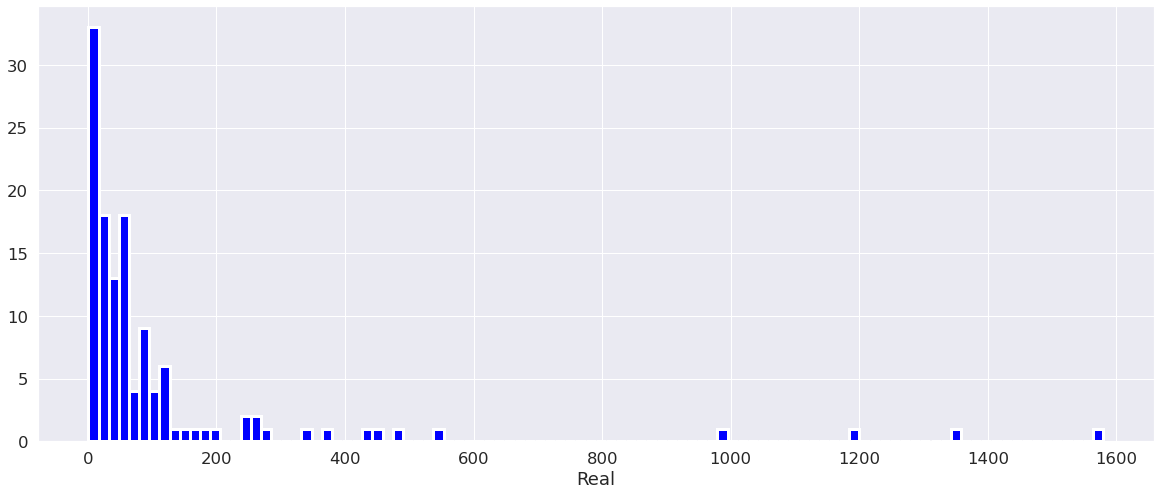

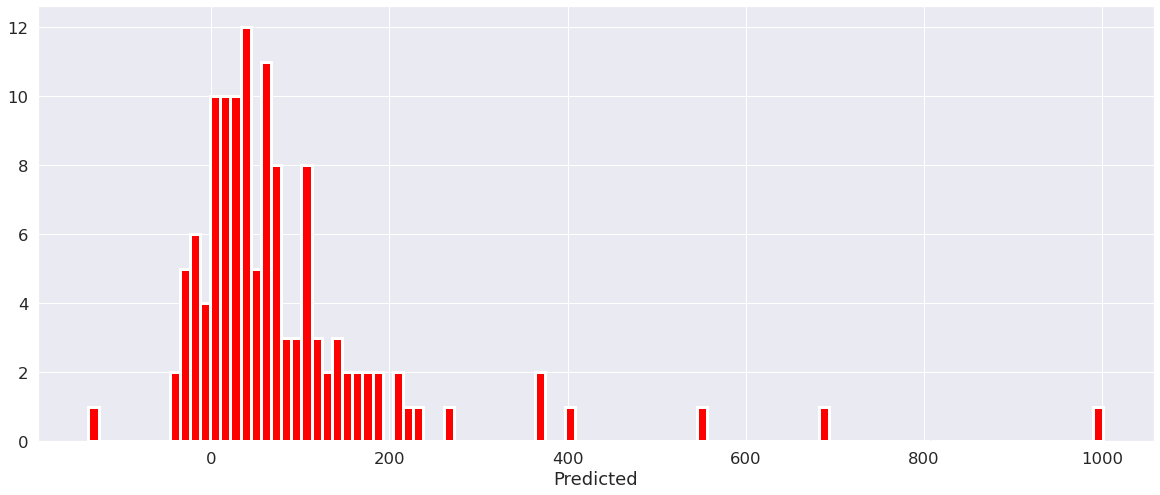


Validating gbm on set 6 and 2017-04
932 122
RMSE : 143.6754
MAPE': 3.8812
MDAPE': 0.8195
MSE: 20642.6066
MAE: 77.5082
R2: 0.5779


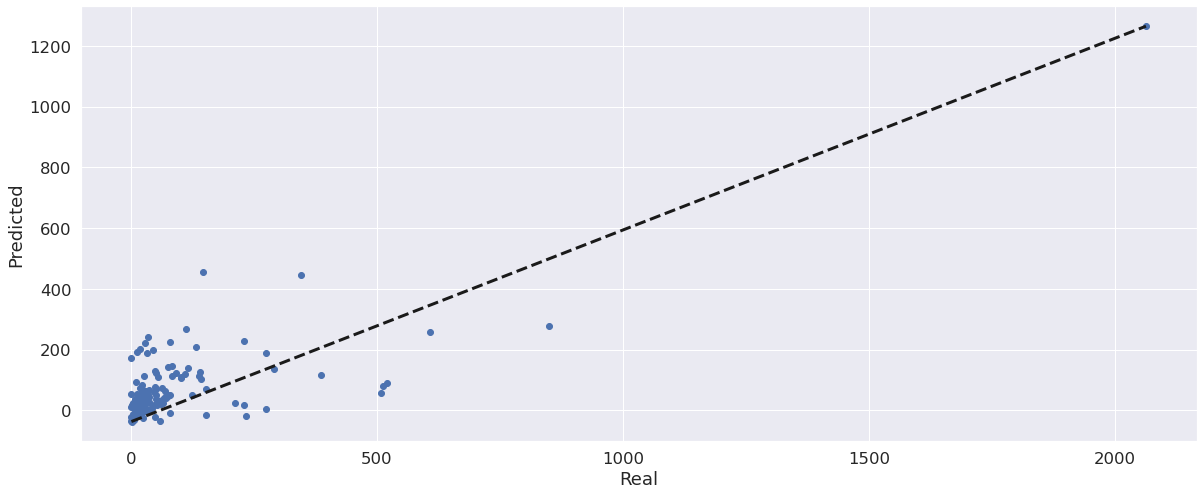

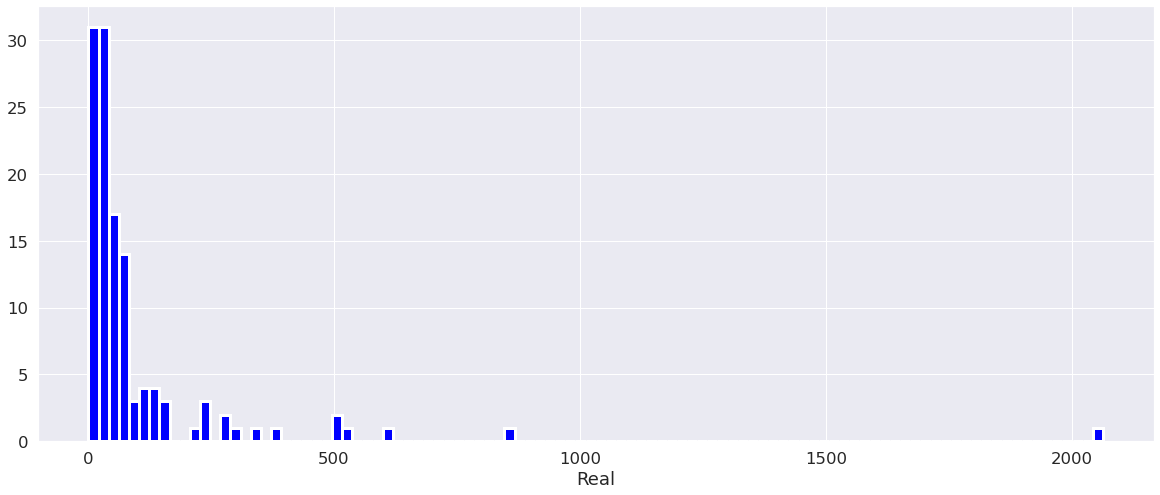

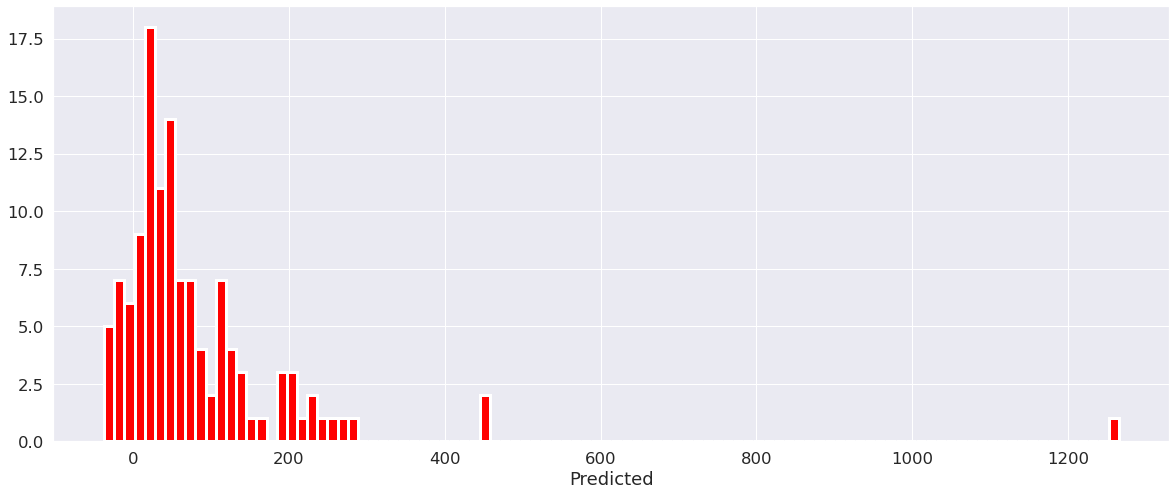


Validating gbm on set 6 and 2017-05
932 121
RMSE : 210.2320
MAPE': 1.9704
MDAPE': 0.7083
MSE: 44197.4959
MAE: 109.0661
R2: 0.4072


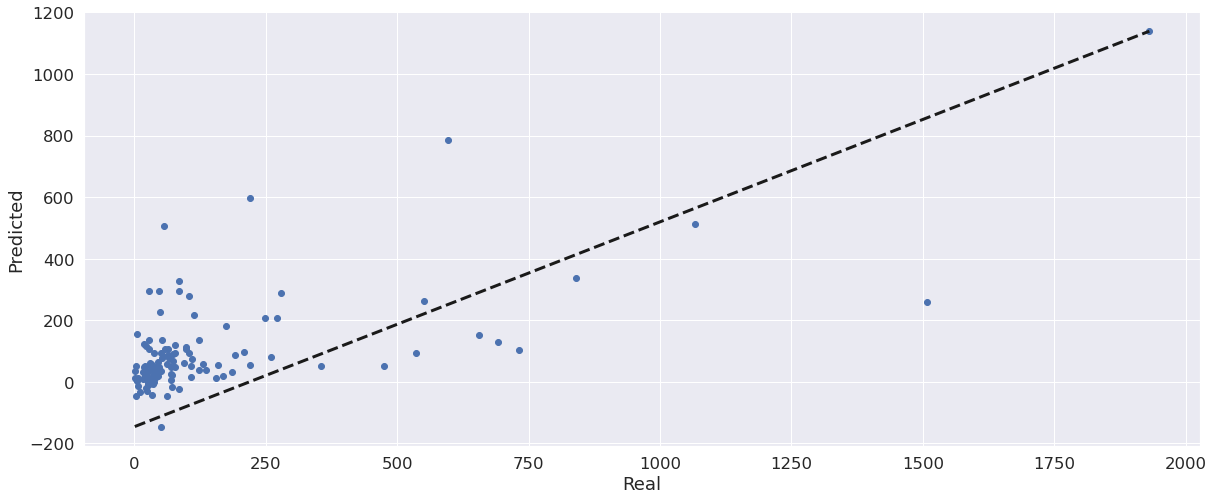

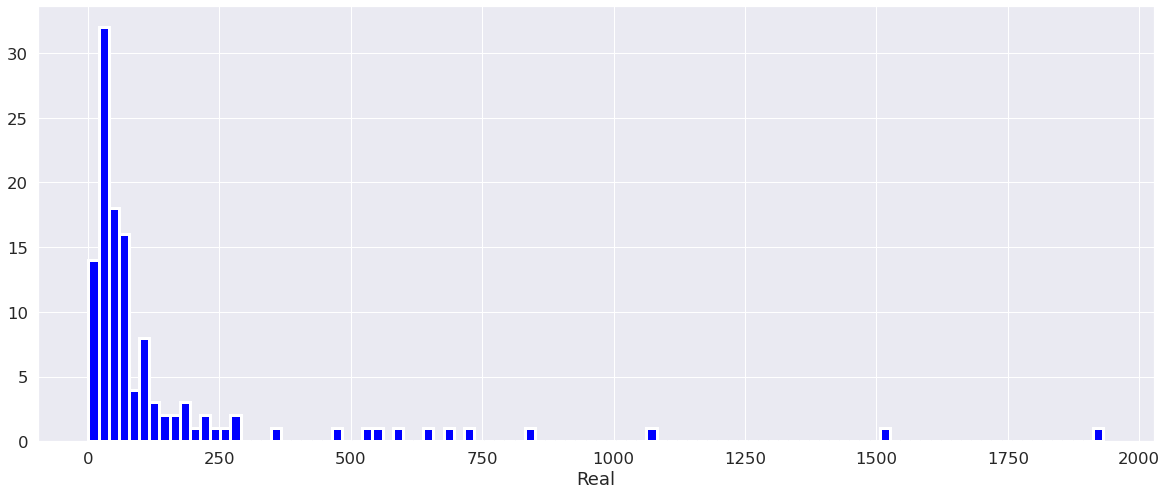

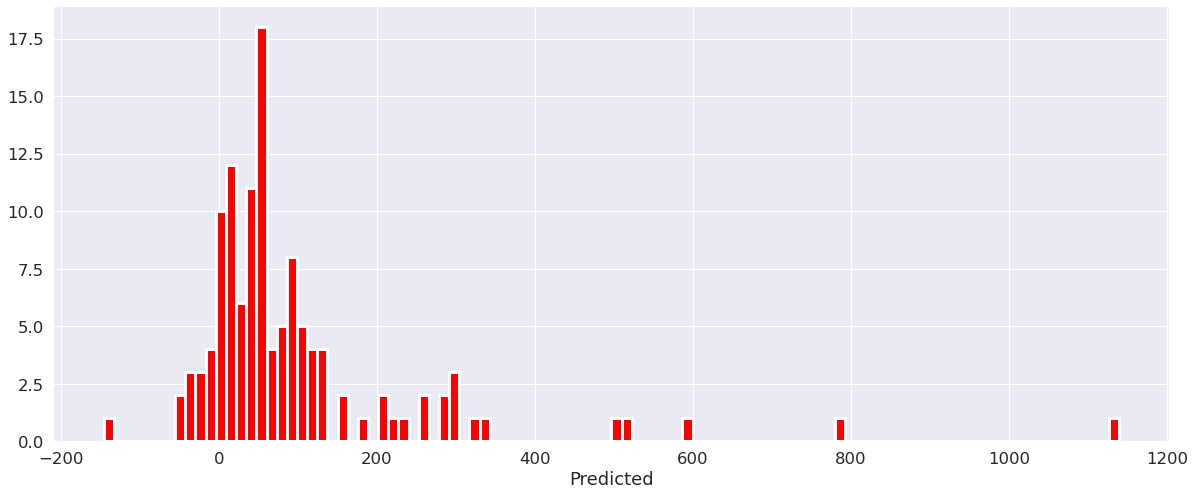


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 185.8502
MAPE': 1.9942
MDAPE': 0.5714
MSE: 34540.3040
MAE: 74.6400
R2: 0.3855


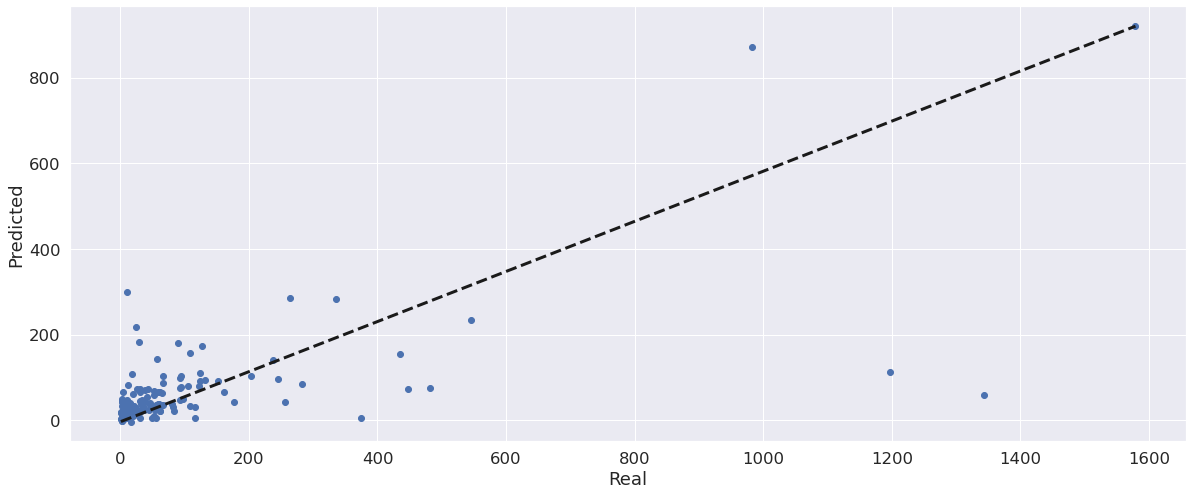

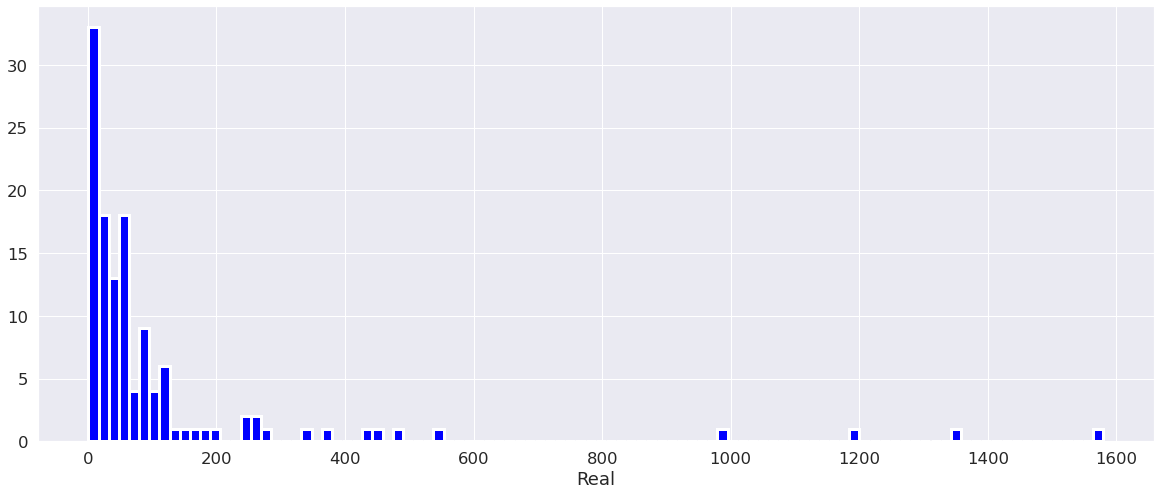

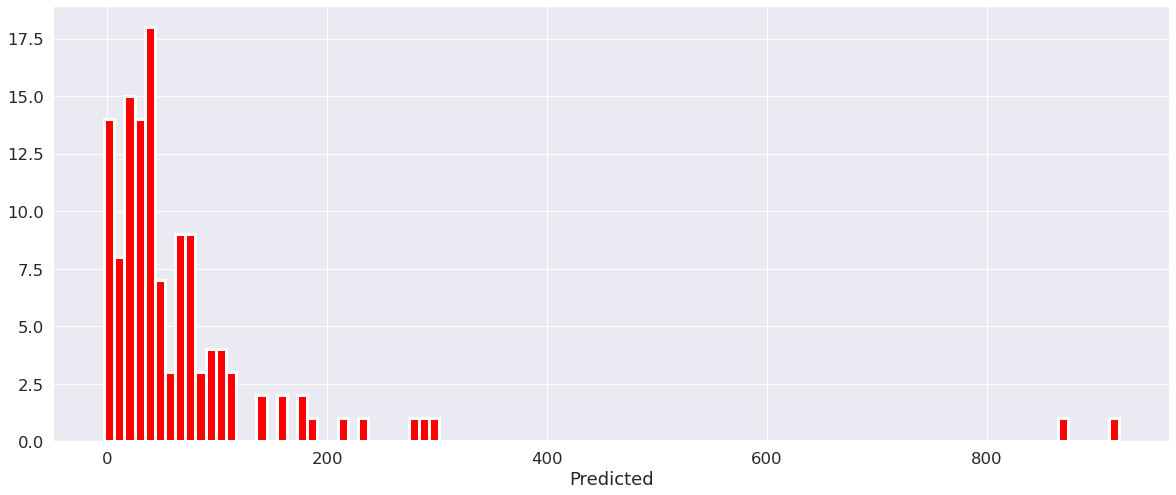


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 155.9079
MAPE': 1.3461
MDAPE': 0.5411
MSE: 24307.2869
MAE: 68.2049
R2: 0.5030


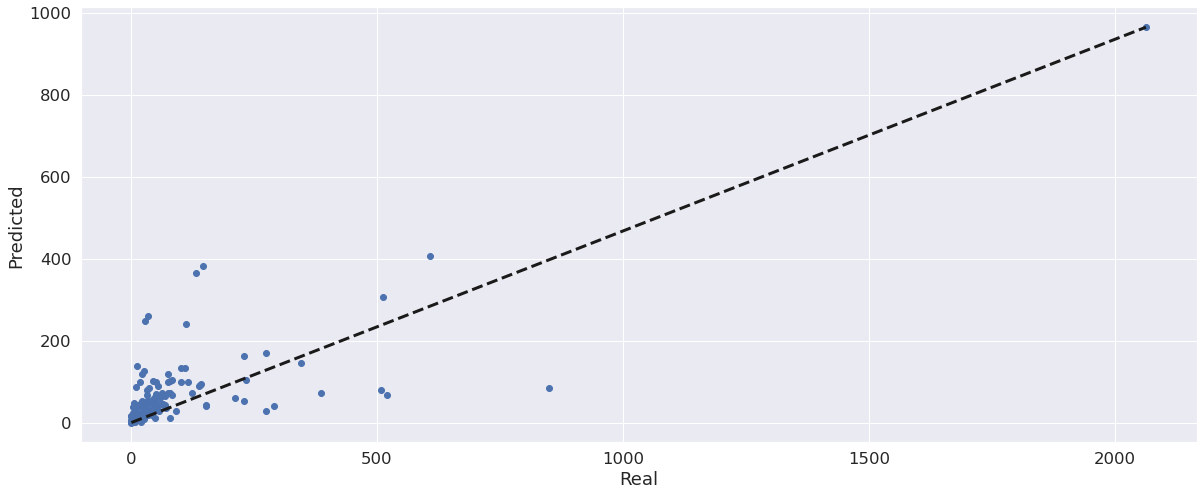

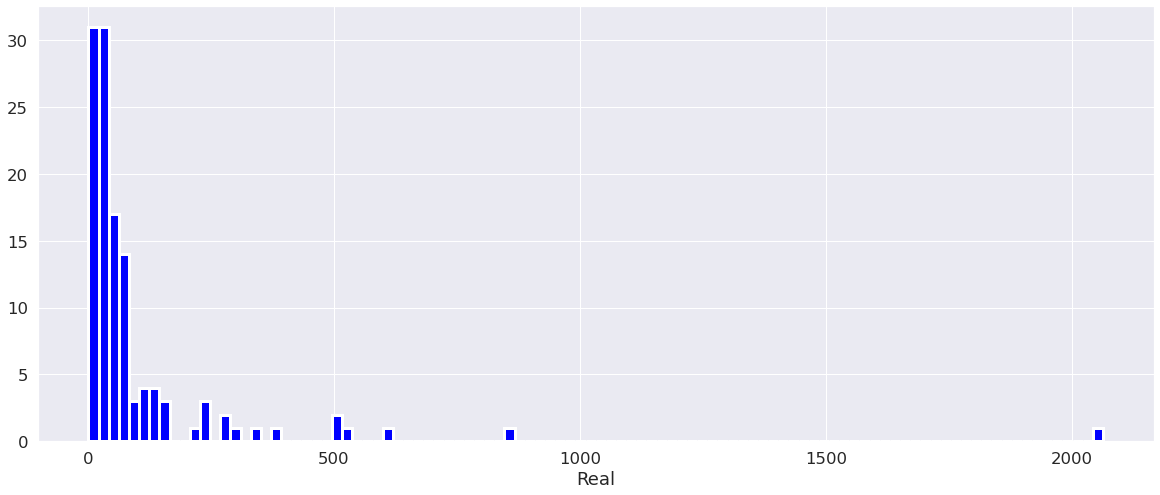

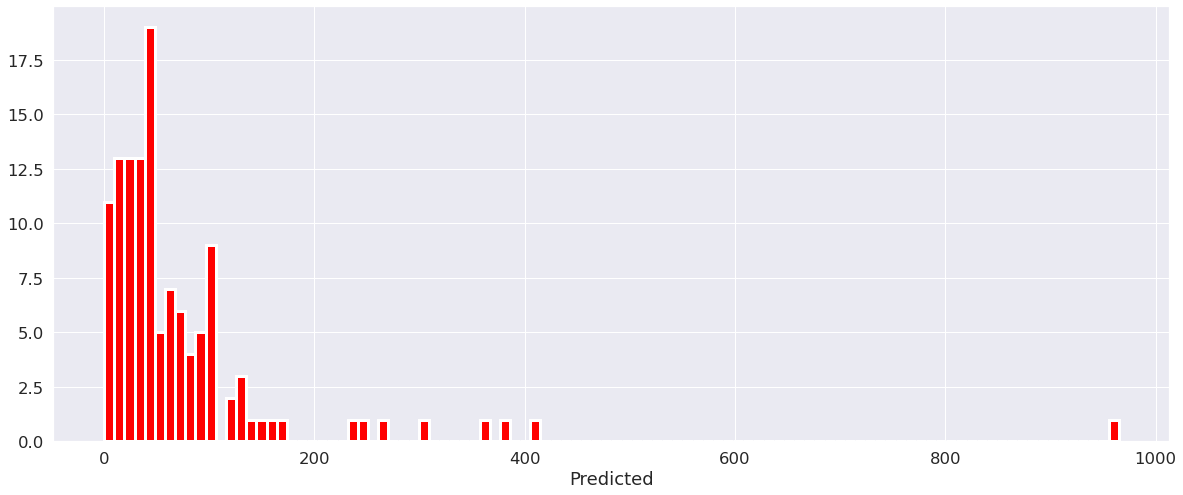


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 215.2902
MAPE': 0.9721
MDAPE': 0.5000
MSE: 46349.8843
MAE: 92.6942
R2: 0.3783


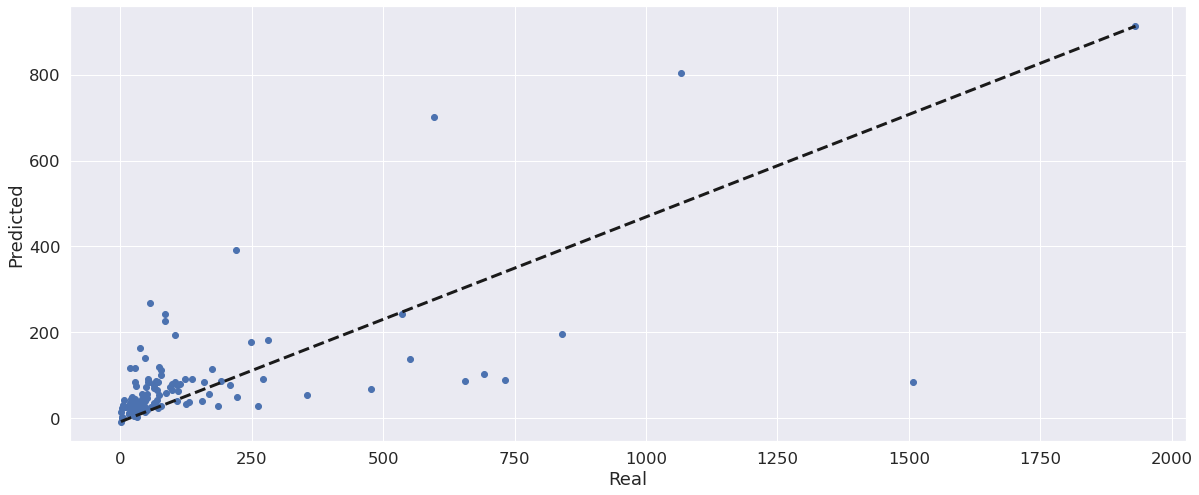

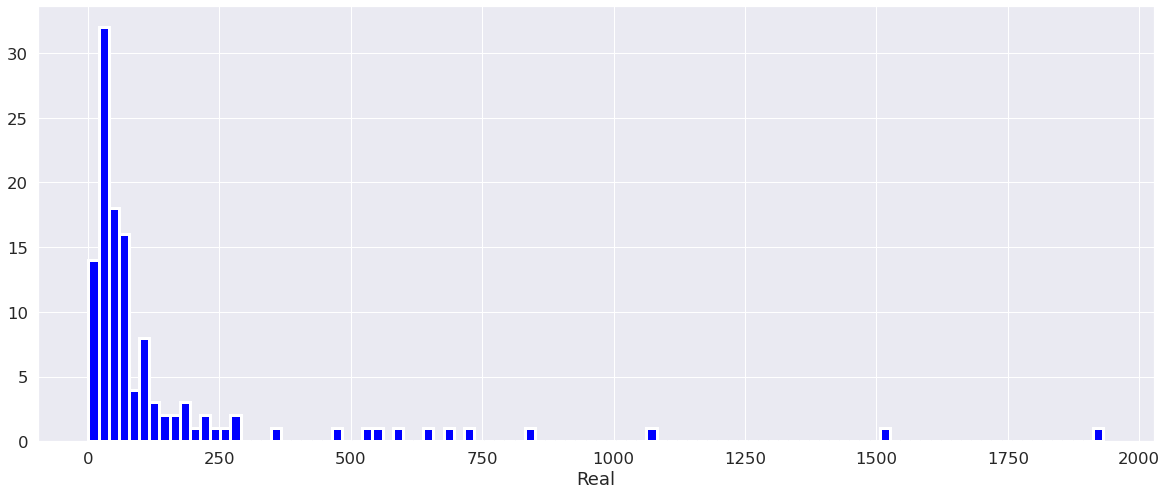

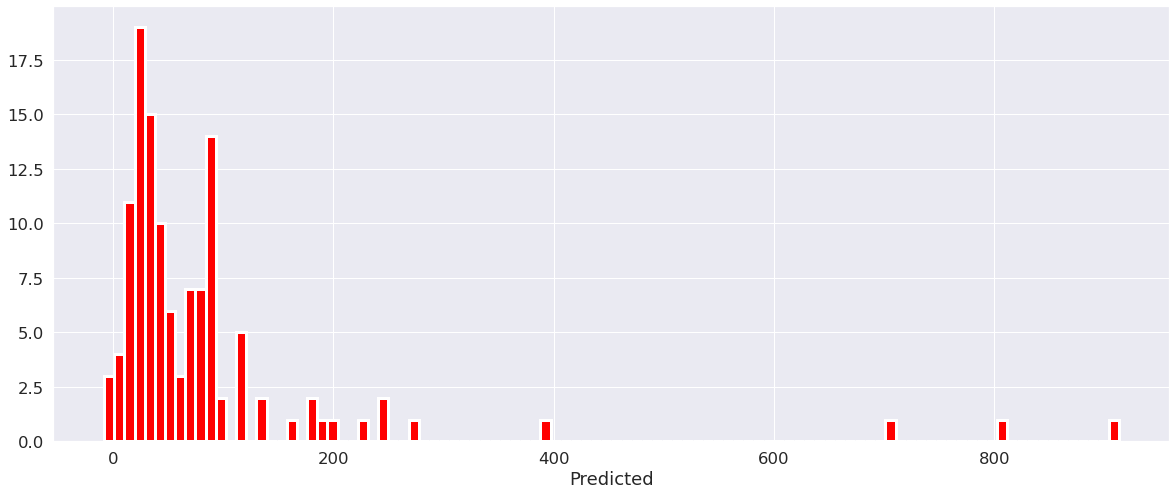


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
932 125
RMSE : 197.1576
MAPE': 1.8596
MDAPE': 0.6439
MSE: 38871.1280
MAE: 76.5680
R2: 0.3085


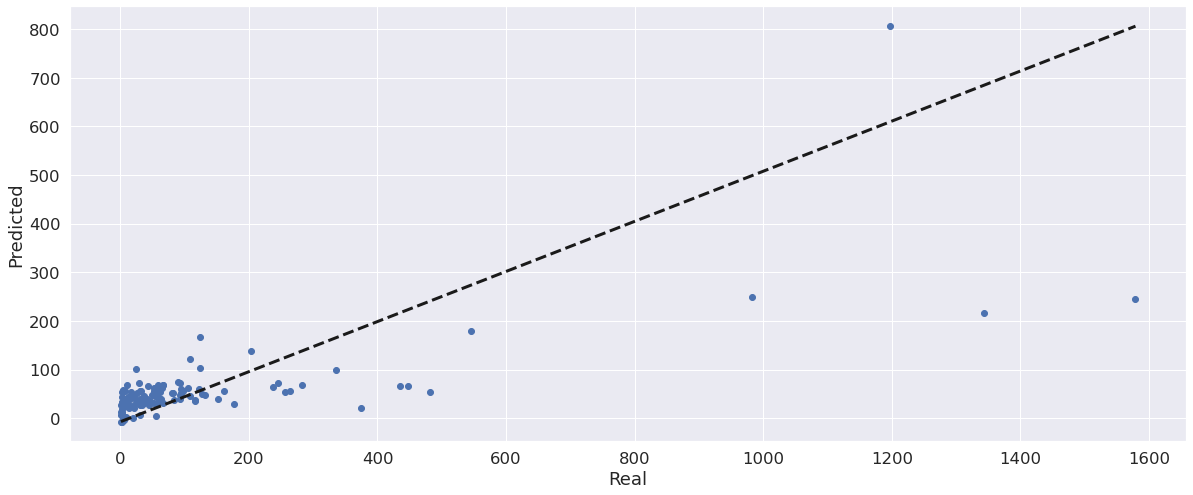

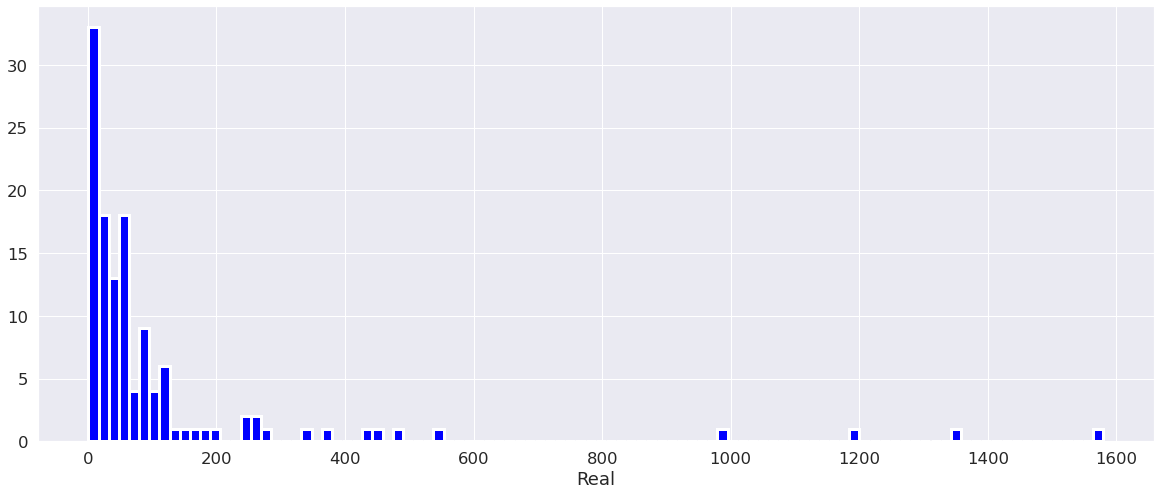

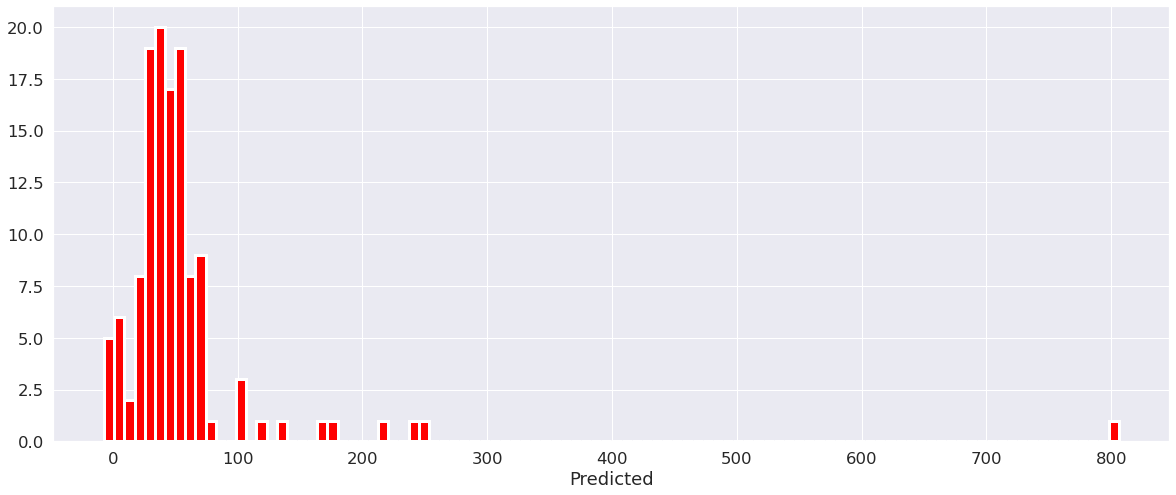


Validating gb_q on set 6 and 2017-04
932 122
RMSE : 189.8315
MAPE': 1.2204
MDAPE': 0.5030
MSE: 36035.9836
MAE: 62.3934
R2: 0.2632


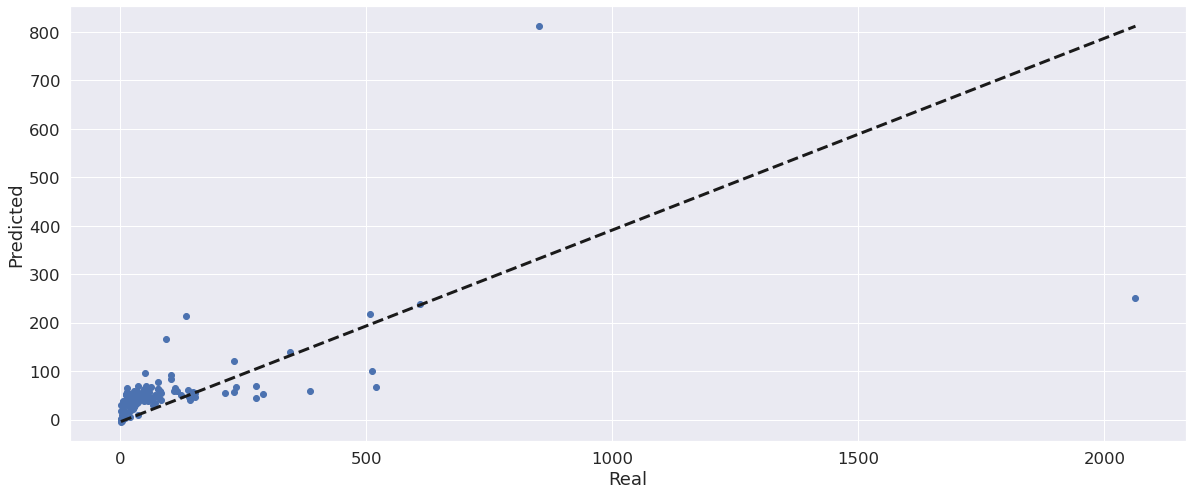

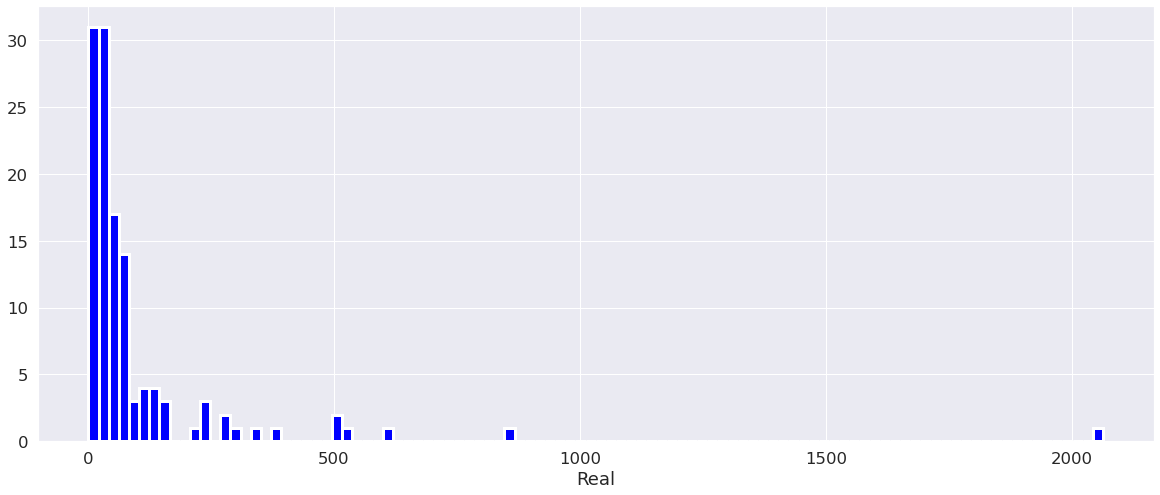

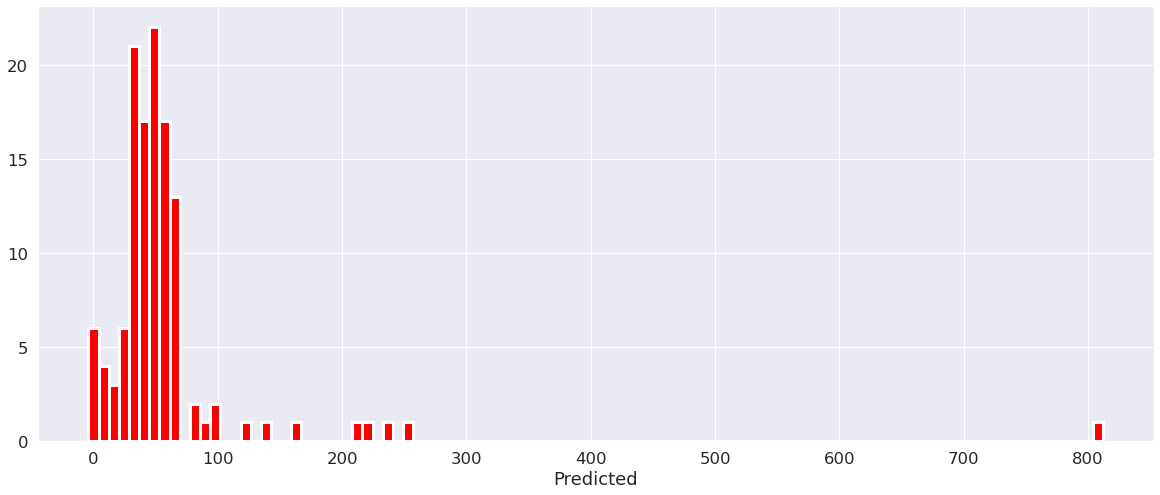


Validating gb_q on set 6 and 2017-05
932 121
RMSE : 236.4062
MAPE': 0.9458
MDAPE': 0.5000
MSE: 55887.8678
MAE: 95.3058
R2: 0.2504


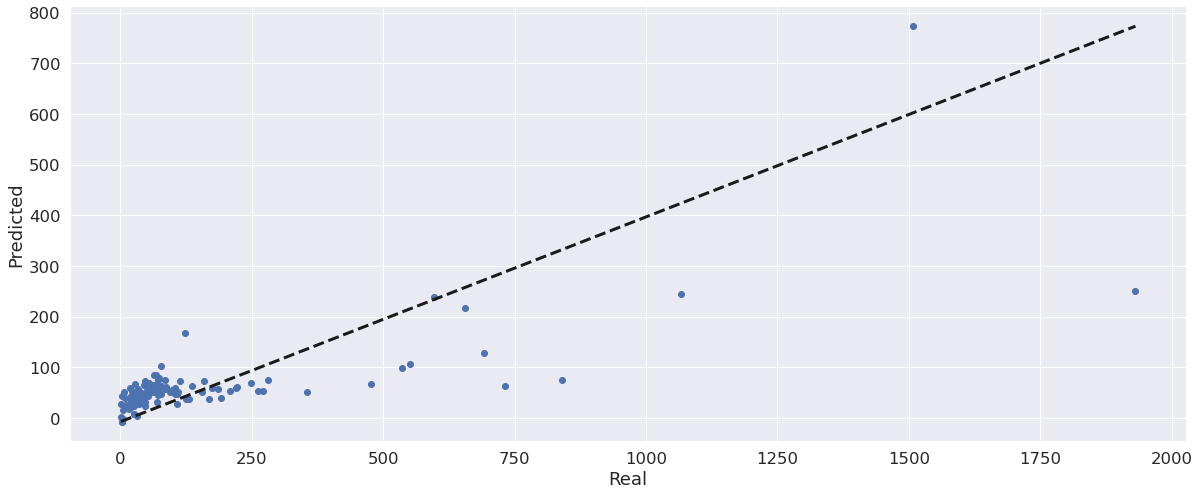

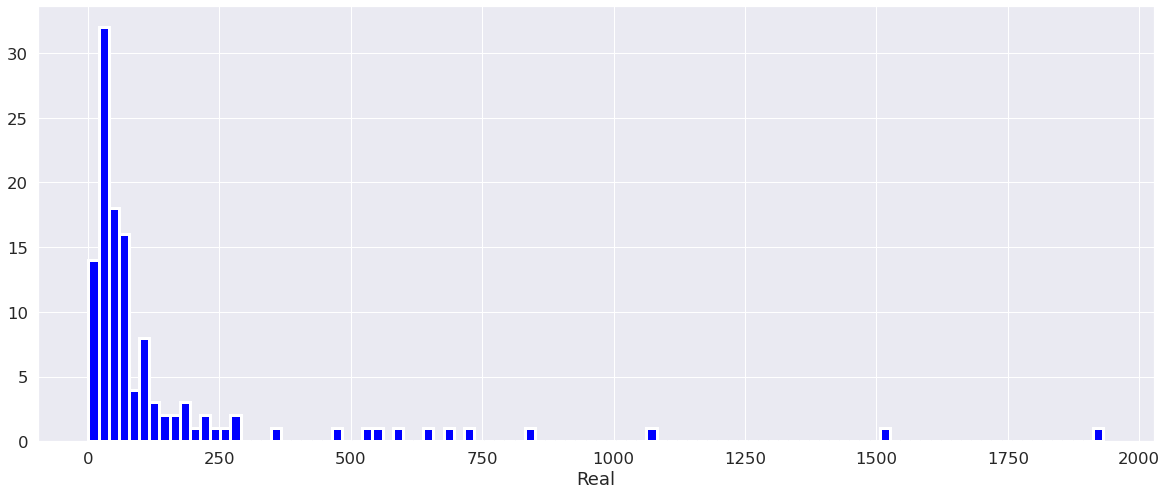

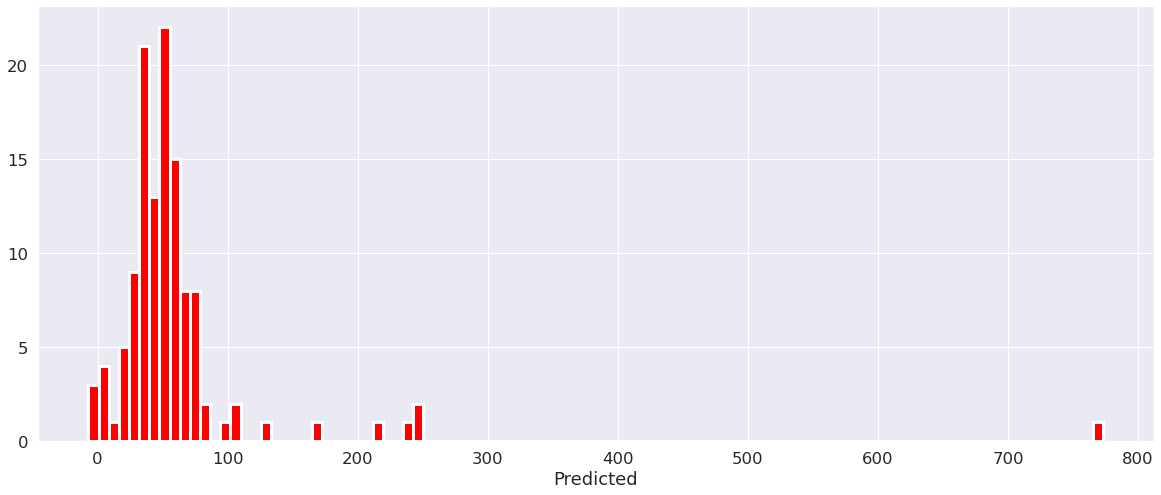

In [22]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [23]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,179.482879,3.706515,0.892033,32214.104000,90.872000,0.426893,LGBMRegressor(random_state=42),gbm,6,2017-03
3,185.850219,1.994214,0.571429,34540.304000,74.640000,0.385509,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,197.157622,1.859588,0.643939,38871.128000,76.568000,0.308461,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
1,143.675351,3.881228,0.819477,20642.606557,77.508197,0.577941,LGBMRegressor(random_state=42),gbm,6,2017-04
4,155.907944,1.346051,0.541117,24307.286885,68.204918,0.503013,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,189.831461,1.220450,0.503012,36035.983607,62.393443,0.263208,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
2,210.232005,1.970423,0.708333,44197.495868,109.066116,0.407197,LGBMRegressor(random_state=42),gbm,6,2017-05
5,215.290233,0.972090,0.500000,46349.884298,92.694215,0.378328,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
8,236.406150,0.945773,0.500000,55887.867769,95.305785,0.250399,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-05
